# Example using KARS (Kernel Approximation of Raman Spectra)

In this example we show how to use KARS to learn an approximation of the CARS spectra from a library of pre-computed spectra.

### 1. Load the package

First, we load up the package which can be found and installed on pypi: [https://pypi.org/project/kars/](https://pypi.org/project/kars/)

In [1]:
import kars

### 2. Load the library data

Next we load in the library data. We have two pre-computed matrices for our example however the precise library data would need to be changed for the specific application of the end-user. The two matrices that we need are
1. A matrix of library parameters that is $N \times P$ where $N$ is the number of library spectra and $P$ is the number of parameters. In this code we look at a case with $P=5$ parameters ($T$,$N_2$,$O_2$,$H_2O$) and $N=750$ library params. We call this matrix `library_params` and load it from the file `library_params.csv`

Note that our method works with any set of parameters it need not be these exact five parameters. 

In [2]:
import pandas as pd
import numpy as np

library_params = pd.read_csv('library_params.csv',header=None) #gas parameters
library_params.columns = ['Temp','N2','H2','O2','H2O']

2. A matrix of library spectra that is $N \times M$ where $M$ is the number of wavenumbers at which the spectra are sampled $N$ is the number of library spectra. These spectra correspond to the parameters loaded in `library_params`. Here we call this `library_spectra` and read it from the `library_spectra.csv` file

Note that we also square-root transform these spectra (although this isn't strictly necessary)

In [3]:
library_spectra = pd.read_csv('library_spectra.csv',header=None) #library spectra
library_spectra = np.sqrt(library_spectra)

We also load in the wavenumbers at which the spectra are sampled. This isn't strictly necessary but informative for plotting.

In [4]:
library_wns = pd.read_csv('wn.csv',header=None).T #wavenumber (not strictly nec.)
w = np.array(library_wns.iloc[0])

### 3. Fit the KARS approximator

Here we pass in the library spectra and parameters to the fit along with the tuning parameter `gamma` (more on this later). 

In [5]:
kf = kars.karsft(train_params = library_params,
           train_ls = library_spectra,
           gamma=1)

### 4. Evaluate fit

To evaluate our data we load in some supplementary validation data in a similar manner. We will predict the spectra for the validation parameters and compare to the true validation spectra. While this would not likely be the way that our method is used in practice (typically it would be used in some optimization routine) this validation data is illustrative of the accuracy of the approach.

In [6]:
val_params = pd.read_csv('val_params.csv',header=None) #gas parameters
val_params.columns = ['Temp','N2','H2','O2','H2O']
val_spectra = pd.read_csv('val_spectra.csv',header=None) #val spectra
val_spectra = np.sqrt(val_spectra)

First we plot an example true and estimated spectra (by KARS)

In [7]:
from matplotlib import pyplot as plt

In [8]:
truth = val_spectra.iloc[0]
pm = np.array([val_params.iloc[0]])

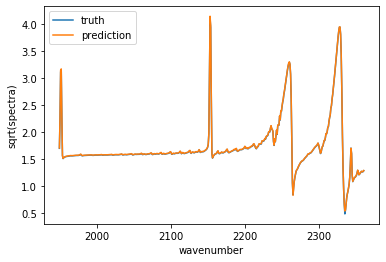

In [9]:
pred = kf.predict(pm).reshape(-1)
plt.plot(w,truth,label='truth');
plt.plot(w,pred,label='prediction')
plt.legend();
plt.xlabel("wavenumber");
plt.ylabel("sqrt(spectra)");

We also can show that KARS can be used to predict multiple spectra at a time

In [10]:
truth = val_spectra.iloc[0:3].T
pm = val_params.iloc[0:3]

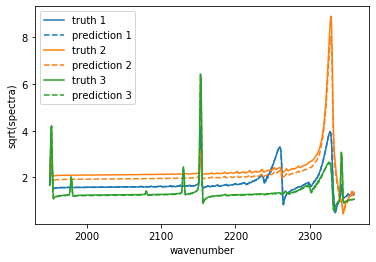

In [11]:
clr_cycle = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
pred = kf.predict(pm).T

for i in range(pred.shape[1]):
    plt.plot(w,truth.iloc[:,i],linestyle='solid',label='truth '+str(i+1),color=clr_cycle[i]);
    plt.plot(w,pred[:,i],linestyle='dashed',label='prediction '+str(i+1),color=clr_cycle[i]);

plt.xlabel("wavenumber");
plt.ylabel("sqrt(spectra)");
plt.legend();

Out of interest, we determine the example where our KARS approximation does worst and plot it:

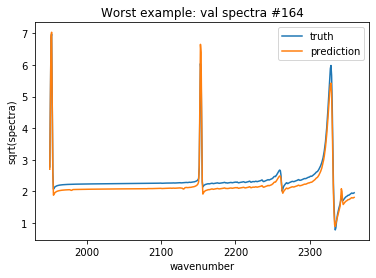

In [12]:
dff = (kf.predict(val_params) - val_spectra)
ii = np.argmax(np.max(dff,axis=1))
truth = val_spectra.iloc[ii]
pm = np.array([val_params.iloc[ii]])
pred = kf.predict(pm).reshape(-1)
plt.plot(w,truth,label='truth');
plt.plot(w,pred,label='prediction')
plt.title("Worst example: val spectra #"+str(ii))
plt.xlabel("wavenumber");
plt.ylabel("sqrt(spectra)");
plt.legend();

### 5. Cross-validation for `gamma`

One way we can improve fits for these cases is by choosing the smoothing parameter `gamma` using cross validation. Note that this cross-validation **does not** use the validation data, it only uses the library data. Thus these routines could be exported directly for use on real data. 

First we set some range of `gamma` values to try out

In [13]:
gma_seq = [10**float(x) for x in np.arange(-5,5,2)]

and then we calculate the cross-validated error using **only** the library data

In [14]:
xv_err = kars.xv_gamma(gma_seq,tpms=library_params,tls=library_spectra)

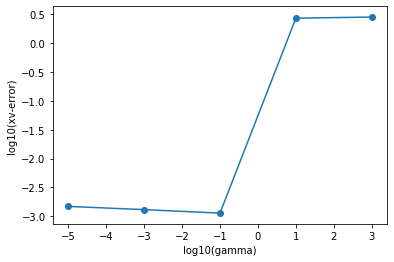

In [15]:
plt.scatter(np.log10(gma_seq),np.log10(xv_err));
plt.plot(np.log10(gma_seq),np.log10(xv_err));
plt.xlabel("log10(gamma)");
plt.ylabel("log10(xv-error)");

we then choose $\gamma^*$ to be the value which minimizes this cross-validated error

In [16]:
gma_star = gma_seq[np.argmin(xv_err)]
gma_star

0.1

and re-fit our kars fit using this value $\gamma^*$

In [17]:
kf = kars.karsft(train_params = library_params,
           train_ls = library_spectra,
           gamma=gma_star)

we can now look at this worst example again and see improvement 

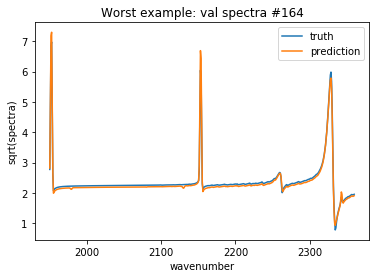

In [18]:
dff = (kf.predict(val_params) - val_spectra)
ii = np.argmax(np.max(dff,axis=1))
truth = val_spectra.iloc[ii]
pm = np.array([val_params.iloc[ii]])
pred = kf.predict(pm).reshape(-1)
plt.plot(w,truth,label='truth');
plt.plot(w,pred,label='prediction')
plt.title("Worst example: val spectra #"+str(ii))
plt.xlabel("wavenumber");
plt.ylabel("sqrt(spectra)");
plt.legend();